### State Farm Distracted Driving: Classifying images based on driver safety

See Also: https://www.kaggle.com/praveenmaripeti/state-farm-distracted-driver-detection-with-keras for NN implemntation with tensorflow

Distracted driving causes a lot of accidents and is 100% preventable. Machine learning algorithms can gage driver safety using 2D dashboard camera images of drivers. The goal is to classify these images based on driver's behavior (cell phone, texting, etc). 

10 behaviors are classfied as follows:

In [1]:
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
#['c'+str(x) for x in range(10)]

class_def = {'c0': 'safe driving',
'c1': 'texting - right',
'c2': 'talking on the phone - right',
'c3': 'texting - left',
'c4': 'talking on the phone - left',
'c5': 'operating the radio',
'c6': 'drinking',
'c7': 'reaching behind',
'c8': 'hair and makeup',
'c9': 'talking to passenger'}

In [21]:
# Import Relevant Libaries
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
#Create and load dataset
import h5py
import pickle # for PCA
#Train Test Split
from sklearn.model_selection import train_test_split
#SVM
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Learning Curve
from sklearn.model_selection import learning_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision

In [3]:
# Some parameters for running the Notebook
# hdf5 filename 
downscale = 5
hdf5_train ="StateFarm_Train_5X.h5" # scaled down by 5
#"StateFarm_Train_2X.h5" # scaled down by 2 
#write image dataset? 
write_dataset = False

#run grid search for svm hyperparameters?
run_gridsearch = False

#PCA/SVM
runFullPCA = False
computeLearningCurve = True
PIK = "pca.dat"
PIK2 = "grid.dat"
PIK_learning = 'learning_xtrain_ytrain.dat'
#learning_X_y_wtf.dat

### Make and/or  Load HDF5 dataset (training data) :
See: https://realpython.com/storing-images-in-python/
and the [github Page](https://github.com/realpython/materials/blob/storing-images/storing-images/storing_images.ipynb)


In [4]:
# directories and filepaths
data_dir = Path(os.path.join(os.getcwd(),'data'))
base_dir = Path(os.path.join(data_dir, "state-farm-distracted-driver-detection"))
img_folder = Path(os.path.join(base_dir, 'imgs'))
train_imgs = Path(os.path.join(img_folder, 'train'))
test_imgs = Path(os.path.join(img_folder, 'test'))
# load the image lists
driver_imgs_list = pd.read_csv(os.path.join(base_dir, 'driver_imgs_list.csv'))
sample_sub = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))

In [5]:
# head of image list
driver_imgs_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
def rescale_image(filepath, resize_scale=2, gray_scale=True):
  '''
  Loads image, converts to grayscale, downsamples by resize_scale and returns a 
  To keep color image, set gray_scale = True 
  To keep the original size of the image, set resize_scale= 1
  '''
  im = Image.open(filepath)
  if gray_scale:
    im = im.convert('L')
  if resize_scale > 1:
    resize_dims = tuple([int(x/resize_scale) for x in (im.size)])
    im = im.resize(resize_dims)
  # makes array 1 X Px X Py for easier concatenation  
  return np.array(im).reshape(1, np.array(im).shape[0], np.array(im).shape[1])

if write_dataset: 
    # NOTE: USING NP ARRAYS IS MUCH SLOWER THAN DOING A LIST
    # For training images data set (could probably parallelize this but...)
    classnames = driver_imgs_list['classname'].values
    labels = [int(x[1]) for x in classnames]
    filenames = driver_imgs_list['img'].values
    image_list = [] # make a list, then concatenate
    for i, file in enumerate(filenames):
        if i%1000  == 0:    
            print(f"adding {file} to list, i={i}") 
            
        path_to_file = Path(os.path.join(train_imgs, classnames[i], file))        
        image_list.append(rescale_image(path_to_file, resize_scale = downscale)) 
    # concatenate images into singe nd array  
    images = np.concatenate(image_list, axis= 0)

In [7]:
if write_dataset: 
    # each image is a row
    # data = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
    
    print('Writing HDF5 file')
    # Create a new HDF5 file
    file = h5py.File(
        data_dir / hdf5_train, "a"
    )

    # Create a dataset in the file
    image_set = file.create_dataset(
        "images",
        np.shape(images),
        h5py.h5t.STD_U8BE,
        data=images,
    )
    classnames_set = file.create_dataset(
        "labels",
        np.shape(labels),
        h5py.h5t.STD_U8BE,
        data=labels,
    )    
    
    file.close()           

Load hdf5 training dataset:


In [8]:
images, labels = [], []

# Open the HDF5 file
file = h5py.File(data_dir / hdf5_train, "r+")
images = np.array(file["/images"]).astype("uint8")
labels = np.array(file["/labels"]).astype("uint8")
file.close()

In [9]:
image_size = images.shape
# Resize images as vectors
X = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
y = labels
# Zero mean 
X = X - X.mean(axis=1).reshape(X.shape[0], 1)

Train, test split

In [10]:
xtrain, xcv, ytrain, ycv = train_test_split(X, y, test_size=0.3, random_state=42)

### SVM: Preprocessing and model parameters

90% of the variance is explained by 160 components (unwhitened)
90% of the variance is explained by 160 components (whitened)
99% of the variance is explained by 2120 components


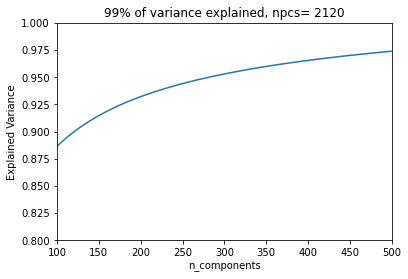

In [11]:
#Going to run pca, let's see how many components we may actually need
if runFullPCA:
    pca = PCA(n_components=0.90,random_state=42, svd_solver='full') # 0.90 of the variance
    pca99 = PCA(n_components=0.99,random_state=42, whiten=True, svd_solver='full') # 0.99 of the variance
    pca90 = PCA(n_components=0.90,random_state=42, whiten=True, svd_solver='full') # 0.90 of the variance
    pca99.fit(xtrain)
    pca90.fit(xtrain)
    # save output as pickle
    with open(PIK, "wb") as f:
        pickle.dump(pca, f)
        pickle.dump(pca90,f)
        pickle.dump(pca99,f)
        
with open(PIK, "rb") as f:
    pca = pickle.load(f)
    pca90 = pickle.load(f)
    pca99 = pickle.load(f)
f.close()
    
print(f"90% of the variance is explained by {pca.n_components_} components (unwhitened)")
print(f"90% of the variance is explained by {pca90.n_components_} components (whitened)")
print(f"99% of the variance is explained by {pca99.n_components_} components")
explained_variance = np.cumsum(pca99.explained_variance_)/(np.sum(pca99.explained_variance_)*.99)
plt.plot(np.arange(pca99.n_components_),explained_variance)
plt.xlim(100,500);
plt.ylim(0.8, 1);
plt.title(f'99% of variance explained, npcs= {pca99.n_components_}')
plt.xlabel('n_components');
plt.ylabel('Explained Variance');    


90% of the variance it is with 160 features! It's a slowly increasing curve which is also slowing down, hitting 95% at 450. At 200 hundred features, 92.5% percent of the variance is explained - doesn't seem worth an extra forty features.

Before doing this systematically, I was running with 150 components on images which were scaled down only 2x and the SVM performed pretty well on the cross validation. At 2x downscale, the size of the images did not allow for a full PCA. The number of pixels far outnumbered the number of training samples. The matrix was only full rank when images were scaled down to 5 times (in integers).  

Next it's time pick the parameters of the SVM via grid search

In [12]:
# initiate pipeline with 160 features
mypca = PCA(n_components=160, whiten=True, random_state= 42)
mysvm = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(mypca, mysvm)

In [13]:
if run_gridsearch:
    param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, .01, .1]}
    # Instantiate the grid search with the model and parameter grid
    grid = GridSearchCV(estimator=model, param_grid=param_grid)
    grid.fit(xtrain, ytrain)
    with open(PIK2, "wb") as f:
        pickle.dump(grid, f)

with open(PIK2, "rb") as f:
    grid = pickle.load(f)
f.close

print(grid.best_params_)
#print(grid.cv_results_)

means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, param in zip(means, stds, grid.cv_results_['params']):
    print("%0.5f (+/-%0.05f) for %r"
          % (mean, std, param))
    # STILL WANNA PICK 0.99433 (+/-0.00037) for {'svc__C': 10, 'svc__gamma': 0.005} (SMALLER STD)

{'svc__C': 5, 'svc__gamma': 0.01}
0.88443 (+/-0.00532) for {'svc__C': 1, 'svc__gamma': 0.0001}
0.94476 (+/-0.00472) for {'svc__C': 1, 'svc__gamma': 0.0005}
0.96400 (+/-0.00293) for {'svc__C': 1, 'svc__gamma': 0.001}
0.99032 (+/-0.00033) for {'svc__C': 1, 'svc__gamma': 0.005}
0.99280 (+/-0.00033) for {'svc__C': 1, 'svc__gamma': 0.01}
0.75975 (+/-0.00769) for {'svc__C': 1, 'svc__gamma': 0.1}
0.93884 (+/-0.00519) for {'svc__C': 5, 'svc__gamma': 0.0001}
0.96987 (+/-0.00305) for {'svc__C': 5, 'svc__gamma': 0.0005}
0.98076 (+/-0.00239) for {'svc__C': 5, 'svc__gamma': 0.001}
0.99357 (+/-0.00031) for {'svc__C': 5, 'svc__gamma': 0.005}
0.99388 (+/-0.00031) for {'svc__C': 5, 'svc__gamma': 0.01}
0.78103 (+/-0.00678) for {'svc__C': 5, 'svc__gamma': 0.1}
0.95190 (+/-0.00410) for {'svc__C': 10, 'svc__gamma': 0.0001}
0.97477 (+/-0.00300) for {'svc__C': 10, 'svc__gamma': 0.0005}
0.98477 (+/-0.00211) for {'svc__C': 10, 'svc__gamma': 0.001}
0.99369 (+/-0.00042) for {'svc__C': 10, 'svc__gamma': 0.005}
0.

99.39% accuracy. This is similar to 99.49% accuracy using the 2x downscaled image with 150pcs. Maybe as good as this SVM may get? 

Let's fit the model and check the predictions of the cross validationset:

In [ ]:
# make model with chocen parameters
mypca = PCA(n_components=160, whiten=True, random_state= 42)
mysvm = SVC(C=5, gamma=0.01,kernel='rbf', class_weight='balanced')
model = make_pipeline(mypca, mysvm)
# fit the model to trianing data
history = model.fit(xtrain, ytrain)

In [19]:
# predict cross validation set
ypred_cv = model.predict(xcv)

In [23]:
print(classification_report(ycv, ypred_cv))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       735
           1       1.00      1.00      1.00       694
           2       1.00      0.99      1.00       691
           3       1.00      0.99      1.00       706
           4       0.99      1.00      0.99       706
           5       1.00      0.99      1.00       693
           6       1.00      1.00      1.00       729
           7       1.00      1.00      1.00       594
           8       0.98      0.99      0.99       568
           9       0.99      0.99      0.99       612

    accuracy                           0.99      6728
   macro avg       0.99      0.99      0.99      6728
weighted avg       0.99      0.99      0.99      6728



### Let's see how the svm/pca model learns
see also: [scikit learn example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py)

In [ ]:
mypca = PCA(n_components=160, whiten=True, random_state= 42)
mysvm = SVC(C=5, gamma=0.01, kernel='rbf', class_weight='balanced')
model = make_pipeline(mypca, mysvm)

if computeLearningCurve: 
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(model, xtrain, ytrain, n_jobs=-1,
                       train_sizes=[0.01, 0.05, 0.1, 0.325, 0.55 , 0.6, 0.775, 1.],
                       return_times=True, random_state=0, shuffle='')
    with open(PIK_learning, "wb") as f:
        pickle.dump(train_sizes, f)
        pickle.dump(train_scores, f)
        pickle.dump(test_scores, f)
        pickle.dump(fit_times,f)

with open(PIK_learning, "rb") as f:
    train_sizes = pickle.load(f)
    train_scores = pickle.load(f)
    test_scores = pickle.load(f)
    fit_times = pickle.load(f)
f.close()



In [ ]:
plt.plot(train_sizes,train_scores);
plt.plot(train_sizes,test_scores);
plt.xlabel('m');
plt.title('Learning Curve: Cross Validation on the Training Data');

Next, I'll be feeding in the whole training dataset X, instead of xtrain and have learning_curve do the cross validation as well. 